## Census Income (KDD) Prediction

Author: Ondrej Prenek
- Github: [@preneond](https://github.com/preneond)
- WWW: https://preneond.me
- Mail: ondra.prenek@gmail.com

Download dataset at http://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)


### Imports

In [4]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## 1. Setup a local environment to run PySpark.

In [ ]:
sc = SparkSession.builder\
        .appName("PySpark Assessment") \
        .master("local[*]") \
        .getOrCreate()

## 2. Download the Census Income [data](http://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD))  

In [3]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census.tar.gz -P data/

--2021-03-08 00:40:31--  http://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9789310 (9,3M) [application/x-httpd-php]
Saving to: ‘data/census.tar.gz.5’

census.tar.gz.5     100%[===================>]   9,33M  4,65MB/s    in 2,0s    

2021-03-08 00:40:34 (4,65 MB/s) - ‘data/census.tar.gz.5’ saved [9789310/9789310]



In [4]:
!tar -xzvf data/census.tar.gz -C data/
!sed 's/?/0/g' data/census-income.data > data/census-income1.data
!sed 's/?/0/g' data/census-income.test > data/census-income1.test 

x census-income.data
x census-income.names
x census-income.test


In [6]:
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DoubleType

schema = StructType([
    StructField('age',IntegerType(), True),
    StructField('class_of_worker', StringType (), True),
    StructField('industry_code', DoubleType (), True),
    StructField('occupation_code', DoubleType (), True),
    StructField('education', StringType (), True),
    StructField('wage_per_hour', DoubleType (), True),
    StructField('enrolled_in_edu_inst_last_wk', StringType (), True),
    StructField('marital_status', StringType (), True),
    StructField('major_industry_code', StringType (), True),
    StructField('major_occupation_code', StringType (), True),
    StructField('race', StringType (), True),
    StructField('hispanic_Origin', StringType (), True),
    StructField('sex', StringType (), True),
    StructField('member_of_a_labor_union', StringType (), True),
    StructField('reason_for_unemployment', StringType (), True),
    StructField('full_or_part_time_employment_stat', StringType (), True),
    StructField('capital_gains', DoubleType (), True),
    StructField('capital_losses', DoubleType (), True),
    StructField('divdends_from_stocks', DoubleType (), True),
    StructField('tax_filer_status', StringType (), True),
    StructField('region_of_previous_residence', StringType (), True),
    StructField('state_of_previous_residence', StringType (), True),
    StructField('detailed_household_and_family_stat', StringType (), True),
    StructField('detailed_household_summary_in_household', StringType (), True),
    StructField('instance_weight', DoubleType (), True),
    StructField('migration_code_change_in_msa', StringType (), True),
    StructField('migration_code_change_in_reg', StringType (), True),
    StructField('migration_code_move_within_reg', StringType (), True),
    StructField('live_in_this_house_1_year_ago', StringType (), True),
    StructField('migration_prev_res_in_sunbelt', StringType (), True),
    StructField('num_persons_worked_for_employer', DoubleType (), True),
    StructField('family_members_under_18', StringType (), True),
    StructField('country_of_birth_father', StringType (), True),
    StructField('country_of_birth_mother', StringType (), True),
    StructField('country_of_birth_self', StringType (), True),
    StructField('citizenship', StringType (), True),
    StructField('own_business_or_self_employed', DoubleType (), True),
    StructField('fill_inc_questionnaire_for_veterans_admin', StringType (), True),
    StructField('veterans_benefits', DoubleType (), True),
    StructField('weeks_worked_in_year', DoubleType (), True),
    StructField('year', DoubleType (), True),
    StructField('income', StringType (), True),
])

### Data loading from downloaded csv files

In [7]:
df_train = sc.read.csv('data/census-income1.data', header=False,  schema=schema)
df_test = sc.read.csv('data/census-income1.test', header=False,  schema=schema)

# drop instance weight column ( suggested in dataset notes)
df_train = df_train.drop('instance_weight')
df_test = df_test.drop('instancee_weight')

categorical_cols = ['class_of_worker', 'education','enrolled_in_edu_inst_last_wk','marital_status', 'major_industry_code', 'major_occupation_code','race', 'hispanic_Origin', 'sex', 'member_of_a_labor_union', 'reason_for_unemployment','full_or_part_time_employment_stat','tax_filer_status','region_of_previous_residence','state_of_previous_residence','detailed_household_and_family_stat', 'detailed_household_summary_in_household', 'migration_code_change_in_msa', 'migration_code_change_in_reg', 'migration_code_move_within_reg', 'live_in_this_house_1_year_ago', 'migration_prev_res_in_sunbelt','family_members_under_18','country_of_birth_father','country_of_birth_mother','country_of_birth_self','citizenship','fill_inc_questionnaire_for_veterans_admin']
numerical_cols = ['age', 'industry_code', 'occupation_code', 'wage_per_hour', 'capital_gains', 'capital_losses', 'divdends_from_stocks', 'num_persons_worked_for_employer', 'own_business_or_self_employed', 'veterans_benefits', 'weeks_worked_in_year', 'year']

# Print first 5 rows
df_train.show(5, truncate=False, vertical=True)

-RECORD 0------------------------------------------------------------------------------
 age                                       | 73                                        
 class_of_worker                           |  Not in universe                          
 industry_code                             | 0.0                                       
 occupation_code                           | 0.0                                       
 education                                 |  High school graduate                     
 wage_per_hour                             | 0.0                                       
 enrolled_in_edu_inst_last_wk              |  Not in universe                          
 marital_status                            |  Widowed                                  
 major_industry_code                       |  Not in universe or children              
 major_occupation_code                     |  Not in universe                          
 race                           

## Data Schema, Summary, # of columns and # of rows

In [8]:
df_train.printSchema()

root
 |-- age: integer (nullable = true)
 |-- class_of_worker: string (nullable = true)
 |-- industry_code: double (nullable = true)
 |-- occupation_code: double (nullable = true)
 |-- education: string (nullable = true)
 |-- wage_per_hour: double (nullable = true)
 |-- enrolled_in_edu_inst_last_wk: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- major_industry_code: string (nullable = true)
 |-- major_occupation_code: string (nullable = true)
 |-- race: string (nullable = true)
 |-- hispanic_Origin: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- member_of_a_labor_union: string (nullable = true)
 |-- reason_for_unemployment: string (nullable = true)
 |-- full_or_part_time_employment_stat: string (nullable = true)
 |-- capital_gains: double (nullable = true)
 |-- capital_losses: double (nullable = true)
 |-- divdends_from_stocks: double (nullable = true)
 |-- tax_filer_status: string (nullable = true)
 |-- region_of_previous_residence: strin

In [9]:
df_train.summary()

DataFrame[summary: string, age: string, class_of_worker: string, industry_code: string, occupation_code: string, education: string, wage_per_hour: string, enrolled_in_edu_inst_last_wk: string, marital_status: string, major_industry_code: string, major_occupation_code: string, race: string, hispanic_Origin: string, sex: string, member_of_a_labor_union: string, reason_for_unemployment: string, full_or_part_time_employment_stat: string, capital_gains: string, capital_losses: string, divdends_from_stocks: string, tax_filer_status: string, region_of_previous_residence: string, state_of_previous_residence: string, detailed_household_and_family_stat: string, detailed_household_summary_in_household: string, migration_code_change_in_msa: string, migration_code_change_in_reg: string, migration_code_move_within_reg: string, live_in_this_house_1_year_ago: string, migration_prev_res_in_sunbelt: string, num_persons_worked_for_employer: string, family_members_under_18: string, country_of_birth_father

In [10]:
print(f'# of rows:\t{df_train.count()}\n# of columns:\t{len(df_train.columns)}')

# of rows:	199523
# of columns:	41


## Table with distinct values of all columns.

In [11]:
import pyspark.sql.functions as f
df_train.select(*[f.collect_set(c).alias(c) for c in df_train.columns]).show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------------+--------------------+--------------------+---------------------+--------------------+--------------------+----------------+-----------------------+-----------------------+---------------------------------+--------------------+--------------------+--------------------+--------------------+----------------------------+---------------------------+----------------------------------+---------------------------------------+----------------------------+----------------------------+------------------------------+-----------------------------+-----------------------------+-------------------------------+-----------------------+-----------------------+-----------------------+---------------------+--------------------+-----------------------------+-----------------------------------------+-----------------+--------------------+------------+---

## Exploratory data analysis and visualization of findings from data.

To simplify visualization, let's convert dataframe into Pandas (if the dataset would be larger, we can use sample)

In [12]:
df_train_pd = df_train.toPandas()

### Data Distribution

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'industry_code'}>,
        <AxesSubplot:title={'center':'occupation_code'}>],
       [<AxesSubplot:title={'center':'wage_per_hour'}>,
        <AxesSubplot:title={'center':'capital_gains'}>,
        <AxesSubplot:title={'center':'capital_losses'}>],
       [<AxesSubplot:title={'center':'divdends_from_stocks'}>,
        <AxesSubplot:title={'center':'num_persons_worked_for_employer'}>,
        <AxesSubplot:title={'center':'own_business_or_self_employed'}>],
       [<AxesSubplot:title={'center':'veterans_benefits'}>,
        <AxesSubplot:title={'center':'weeks_worked_in_year'}>,
        <AxesSubplot:title={'center':'year'}>]], dtype=object)

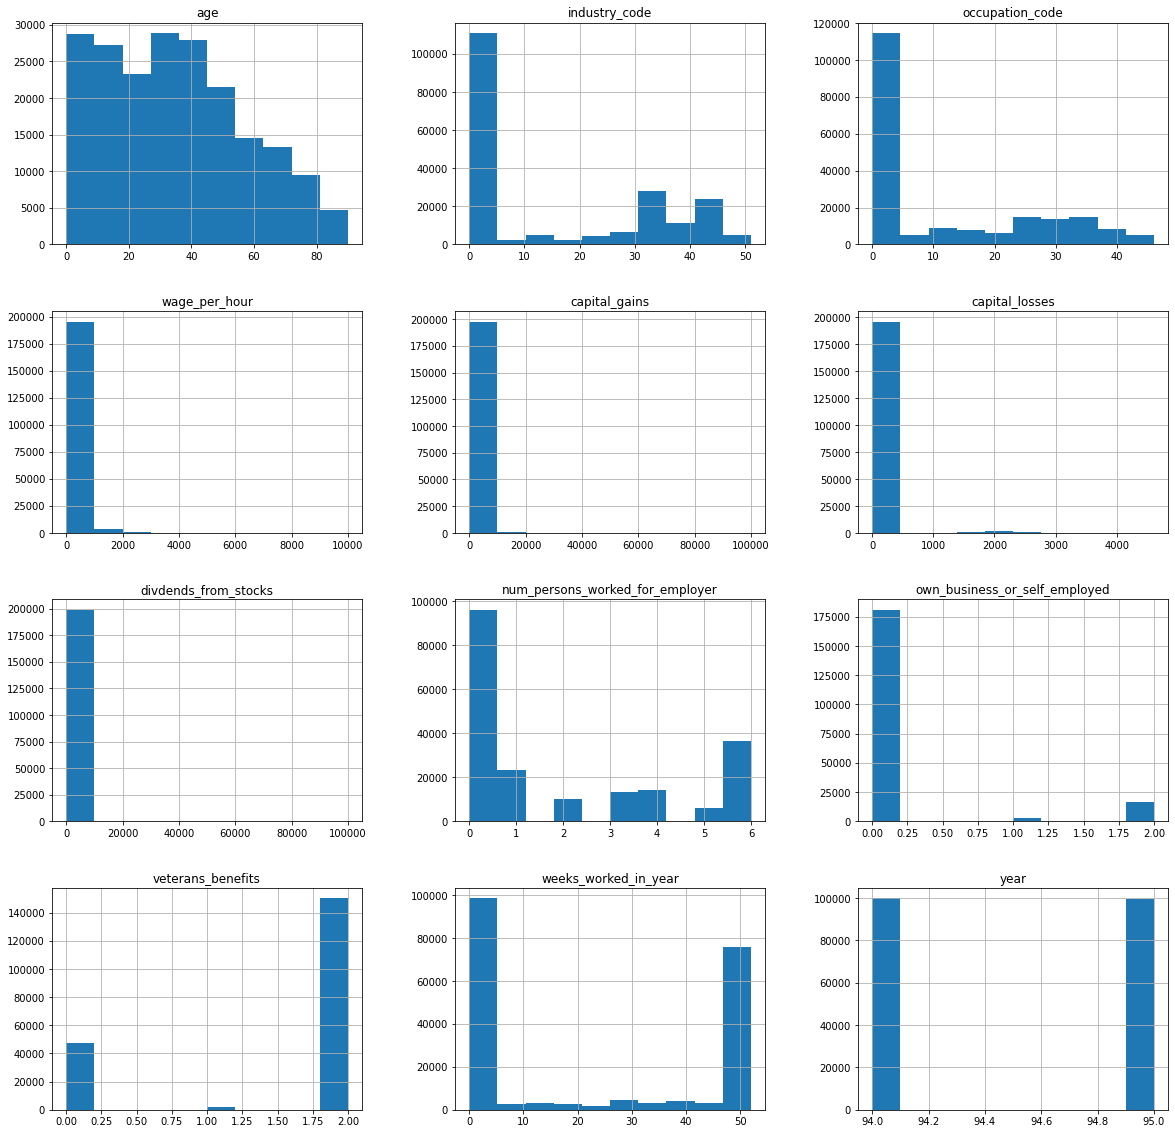

In [13]:
# all data
df_train_pd.hist(bins=10, figsize=(20,20))

#### Histograms separated by outcome


income
 - 50000.    [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
 50000+.     [[AxesSubplot(0.125,0.725918;0.215278x0.154082...
dtype: object

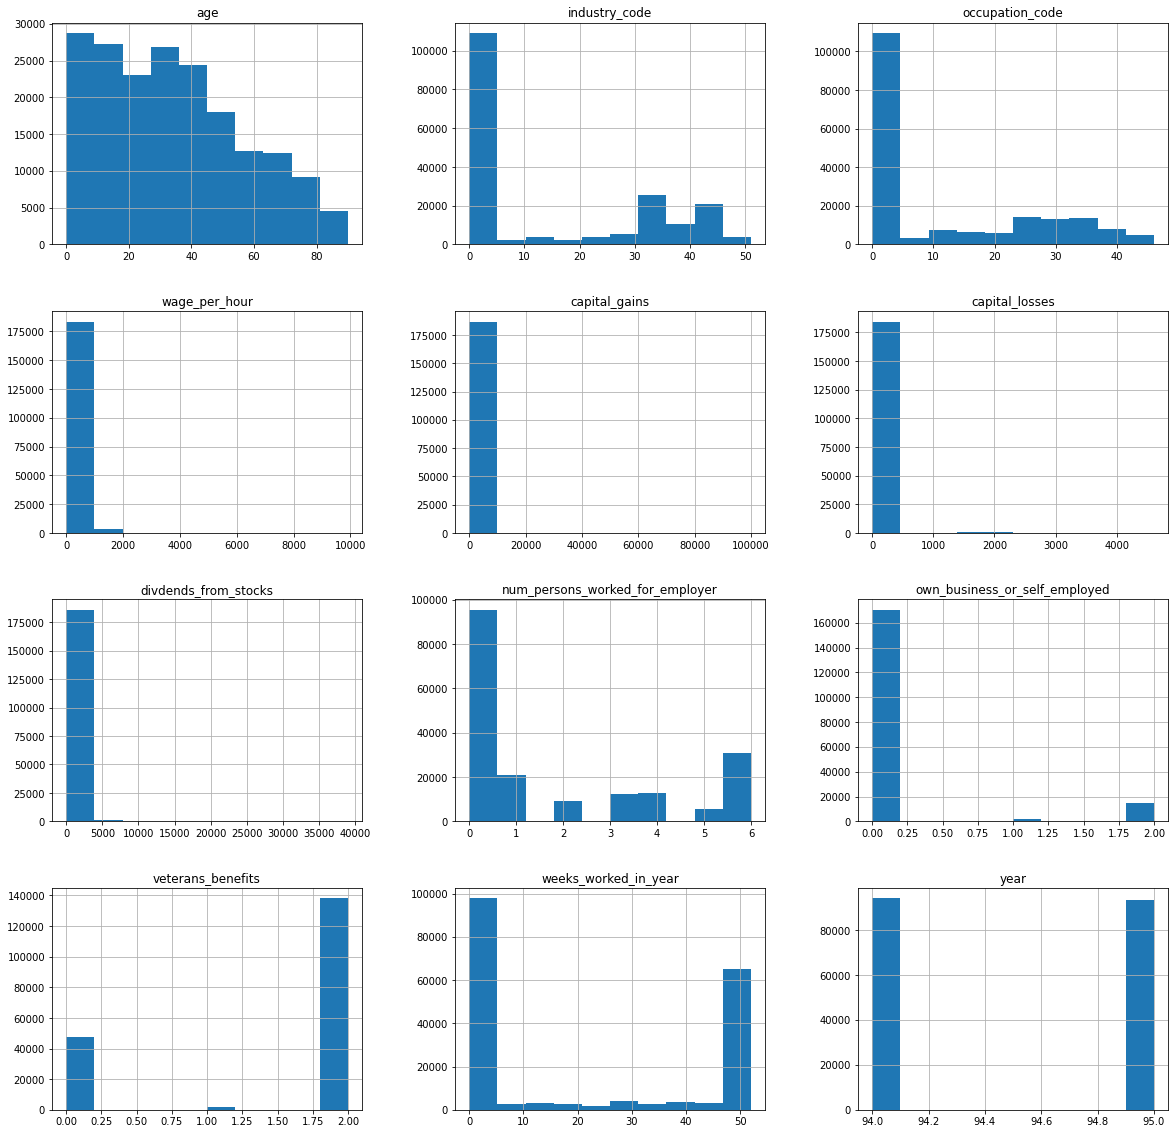

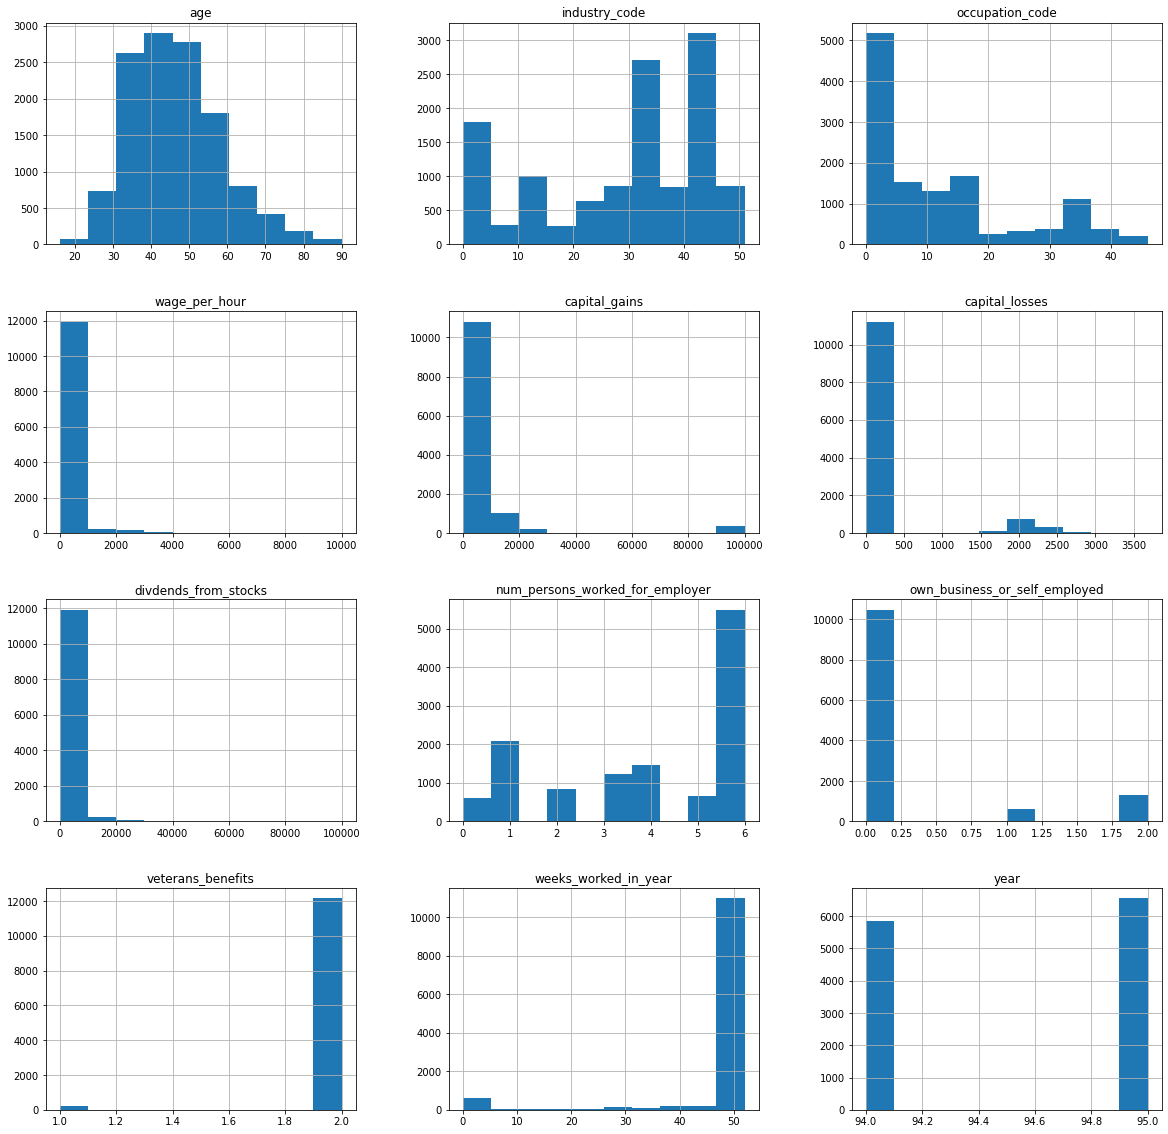

In [14]:
df_train_pd.groupby('income').hist(bins=10, figsize=(20,20))

### Distributions of categorical variables

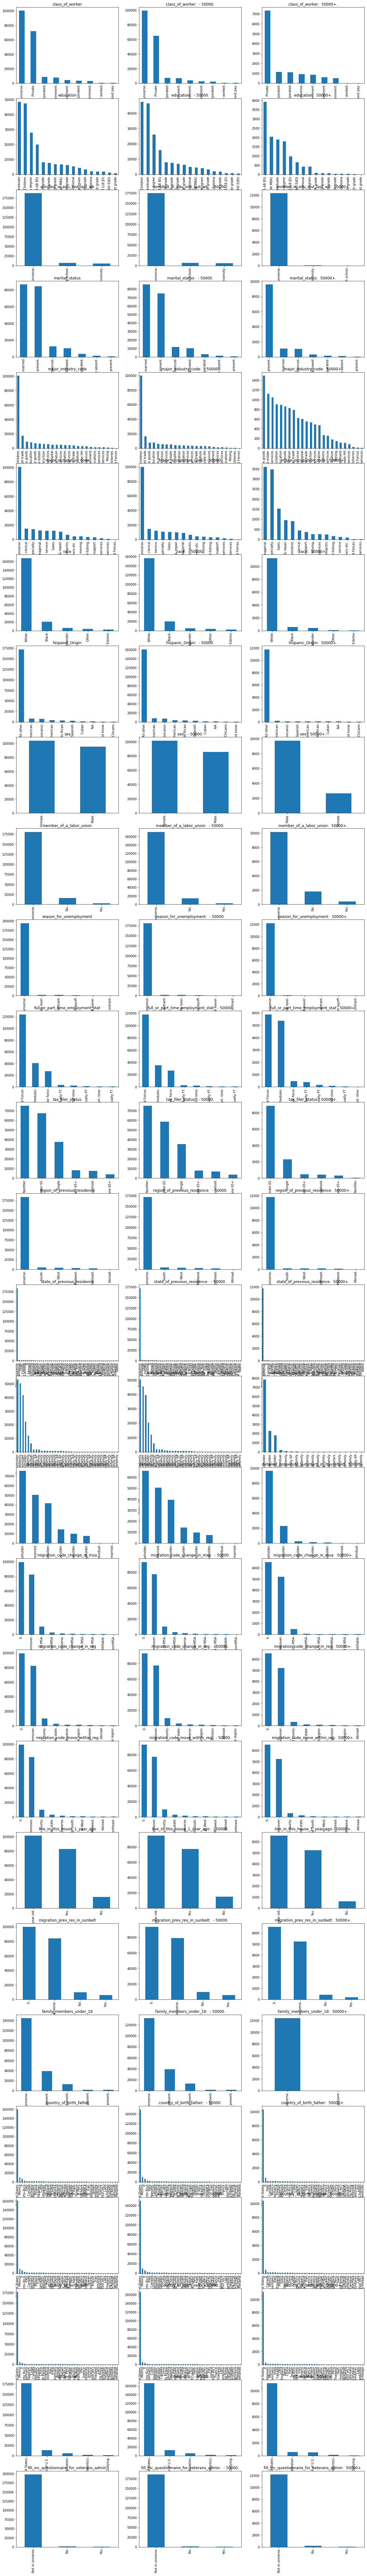

In [15]:
# get categorical and boolean features
cat_bool_col = [col[0] for col in df_train.dtypes if col[1] == 'string' and col[0] != 'income']

# group by values by outcome
train_set_pd_grouped = dict(list(df_train_pd.groupby(['income'])))
classes = list(train_set_pd_grouped.keys())

# create a one large plot
fig, ax = plt.subplots(len(cat_bool_col), 3, figsize=(20,150))

# for each variable add 3 plots
for num_var, var in enumerate(cat_bool_col):
    df_train_pd[var].value_counts().plot(kind="bar", ax=ax[num_var][0], title=var)
    for num_outcome, outcome in enumerate(classes):
        train_set_pd_grouped[outcome][var].value_counts().plot(kind="bar", ax=ax[num_var][1 + num_outcome], 
                                                               title='{}: {}'.format(var, outcome))

plt.show()

### Correlation Matrix

<AxesSubplot:>

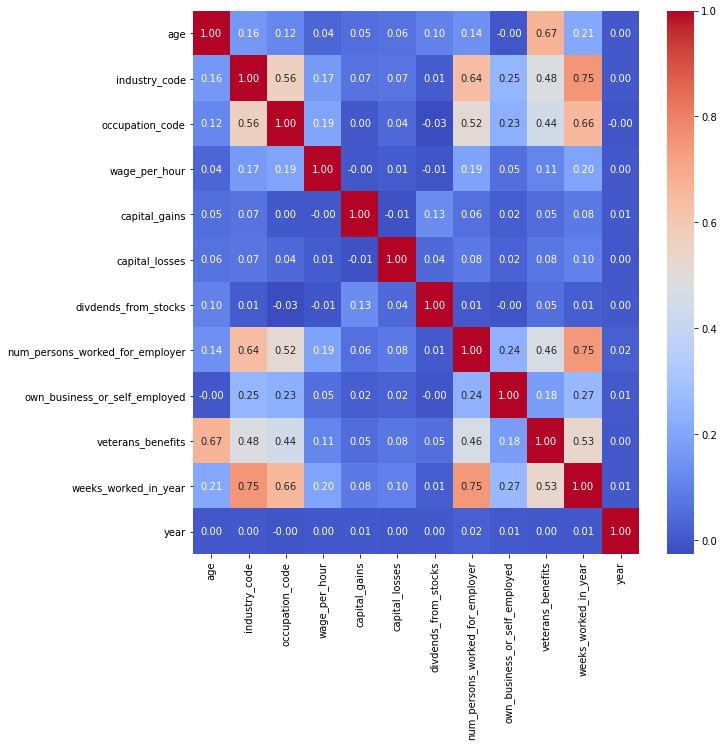

In [16]:
plt.figure(figsize = (10,10))
sns.heatmap(df_train_pd.corr(), annot=True, fmt = ".2f", cmap = "coolwarm")

### Income vs Age

We can see that an amount of the income depends on the age and so does the income category.

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


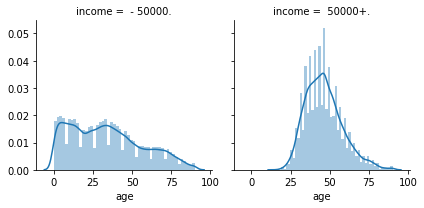

In [17]:
g = sns.FacetGrid(df_train_pd, col='income')
g = g.map(sns.distplot, 'age')
plt.show()

## Creation of binary target variable to predict income 50k and above, and below 50k.

In [18]:
from pyspark.ml.feature import StringIndexer
from pyspark.sql.types import IntegerType

mapping= {' - 50000.': '0',' 50000+.': '1'}


df_train = df_train.replace(to_replace=mapping, subset=['income'])
df_train = df_train.withColumn('income', df_train['income'].cast(IntegerType()))

df_test = df_test.replace(to_replace=mapping, subset=['income'])
df_test = df_test.withColumn('income', df_test['income'].cast(IntegerType()))

df_train.select('income').distinct().show()

+------+
|income|
+------+
|     1|
|     0|
+------+



## Selecting the most promising features without using any ML model (assume that dataset contains many features, and you cannot train a model on all of them).

There are multiple methods that we can use. At the moment, the most usual process is to train (some) ML model and find out the feature importance out of it. 

However, there are other methods that we can use. 

One of them is to find out **feature correlation** with target (income). I will demonstrate this one. 

The other method that can be used to perform feature selection without ML models is **Chi-squared test**.

### Correlation Matrix
Correlation matrix is a table showing correlation coefficients between variables Each cell in the table shows the correlation between two variables.

The correlation coefficient is a statistical measure of the strength of the relationship between the relative movements of two variables. The values range between -1.0 and 1.0. A calculated number greater than 1.0 or less than -1.0 means that there was an error in the correlation measurement. 
- Correlation of -1.0 shows a perfect negative correlation
- Correlation of 1.0 shows a perfect positive correlation
- Correlation of 0.0 shows no linear relationship between the movement of the two variables.

These are the features that are sorted by correlation. Thus, they may have biggest influence on decision process of the final model (first one is target, which is obvious). We need to be aware of the fact that *correlation does not imply causation*

In [22]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

def correlation_matrix(df, corr_columns, method='pearson'):
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols=corr_columns, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, vector_col, method)

    result = matrix.collect()[0]["pearson({})".format(vector_col)].values
    return pd.DataFrame(result.reshape(-1, len(corr_columns)), columns=corr_columns, index=corr_columns)

cm = correlation_matrix(df_train, numerical_cols + ['income'])
cm['income'].sort_values(ascending=False)

income                             1.000000
weeks_worked_in_year               0.262316
capital_gains                      0.240725
num_persons_worked_for_employer    0.222684
industry_code                      0.196190
divdends_from_stocks               0.175779
capital_losses                     0.147417
veterans_benefits                  0.140930
age                                0.135720
own_business_or_self_employed      0.040473
wage_per_hour                      0.024528
year                               0.014794
occupation_code                    0.013414
Name: income, dtype: float64

## Should the raw model dataset be randomly distributed to Train/Test before or after identifying the most predictive features?

To prevent some information leakage (which would cause overfitting) I would split dataset to Train/Test first.

I think it's a good practice to **NOT** use test dataset in any stage of model building. That includes feature selection, too.

## Feature engineering

From the distribution plots above, we can see that some categorical features have high class imbalance that can cause problems, so I suggest to drop them

More specifically:

- 'country_of_birth_father'

- 'country_of_birth_mother'

- 'citizenship'

- 'hispanic_Origin'

- 'fill_inc_questionnaire_for_veterans_admin'

- 'state_of_previous_residence'

- 'enrolled_in_edu_inst_last_wk'

- 'race'

- 'reason_for_unemployment'

- 'region_of_previous_residence'

In [23]:
cols2drop = ['country_of_birth_father','country_of_birth_mother','citizenship','hispanic_Origin','fill_inc_questionnaire_for_veterans_admin','state_of_previous_residence','enrolled_in_edu_inst_last_wk','race','reason_for_unemployment','region_of_previous_residence']
df_train = df_train.drop(*cols2drop)
df_test = df_test.drop(*cols2drop)

for c in cols2drop:
    categorical_cols.remove(c)

We can bin *country of birth self* into continents ([Germany, Czech Republic,..]= Europe, ...) - That will help increase data density for each category. The other reason why to perform such aggregation is that the countries in one continent are close to each other's economic situation

In [24]:
# import pycountry_convert as pc
birthcountryself_categories = [' United-States', ' Mexico', ' Puerto-Rico', ' Peru', ' Canada', ' South Korea', ' India', ' Japan', ' Haiti', ' El-Salvador', ' Dominican-Republic', ' Portugal', ' Columbia', ' England', ' Thailand', ' Cuba', ' Laos', ' Panama', ' China', ' Germany', ' Vietnam', ' Italy', ' Honduras', ' Outlying-U S (Guam USVI etc)', ' Hungary', ' Philippines', ' Poland', ' Ecuador', ' Iran', ' Guatemala', ' Holand-Netherlands', ' Taiwan', ' Nicaragua', ' France', ' Jamaica', ' Scotland', ' Yugoslavia', ' Hong Kong', ' Trinadad&Tobago', ' Greece', ' Cambodia', ' Ireland', '?']
# citizenship_continents = list(map(pc.country_name_to_country_alpha2, citizenship_categories))
birthcountryself_country_codes = ['US', 'MX', 'PR', 'PE', 'CA', 'KR', 'IN', 'JP', 'HT', 'SV', 'DO', 'PT', 'CO', 'GB', 'TH', 'CU', 'LA', 'PA', 'CN', 'DE', 'VN', 'IT', 'HN', 'US','HU', 'PH', 'PL', 'EC', 'IR', 'GT', 'NL', 'TW', 'NI', 'FR', 'JM', 'GB', 'HR', 'HK', 'TT', 'GR', 'KH', 'IE', 'Unknown']
# citizenship_continents = list(map(pc.country_alpha2_to_continent_code, citizenship_country_codes))
birthcountryself_continents = ['NA', 'NA', 'NA', 'SA', 'NA', 'AS', 'AS', 'AS', 'NA', 'NA', 'NA', 'EU', 'SA', 'EU', 'AS', 'NA', 'AS', 'NA', 'AS', 'EU', 'AS', 'EU', 'NA', 'US','EU', 'AS', 'EU', 'SA', 'AS', 'NA', 'EU', 'AS', 'NA', 'EU', 'NA', 'EU', 'EU', 'AS', 'NA', 'EU', 'AS', 'EU', 'Unknown']
birthcountryself_continents_mapping =  {country: continent  for country,continent in zip(birthcountryself_categories, birthcountryself_continents)}

df_train = df_train.replace(to_replace=birthcountryself_continents_mapping, subset=['country_of_birth_self']).withColumnRenamed('country_of_birth_self', 'continent_of_birth_self')
df_test = df_test.replace(to_replace=birthcountryself_continents_mapping, subset=['country_of_birth_self']).withColumnRenamed('country_of_birth_self', 'continent_of_birth_self')

categorical_cols.remove('country_of_birth_self')
categorical_cols.append('continent_of_birth_self')

df_train.select('continent_of_birth_self').distinct().show()

+-----------------------+
|continent_of_birth_self|
+-----------------------+
|                     NA|
|                     SA|
|                     US|
|                      0|
|                     AS|
|                     EU|
+-----------------------+



Other mapping that we can do is to map education - university/nouniversity -> education_class

In [25]:
# define mappings
nouniversity_categories = [' Children',' Less than 1st grade',' 1st 2nd 3rd or 4th grade',' 5th or 6th grade', ' 7th and 8th grade',' 9th grade',' 10th grade',' 11th grade',' 12th grade no diploma',' High school graduate']
education_mapping = {val: 'no_university' for val in nouniversity_categories}
df_train = df_train.replace(to_replace=education_mapping, subset=['education'])
df_test = df_test.replace(to_replace=education_mapping, subset=['education'])

university_categories = [' Bachelors degree(BA AB BS)',' Some college but no degree',' Masters degree(MA MS MEng MEd MSW MBA)',' Associates degree-occup /vocational',' Associates degree-academic program',' Doctorate degree(PhD EdD)',' Prof school degree (MD DDS DVM LLB JD)']
education_mapping = {val: 'university' for val in university_categories}
df_train = df_train.replace(to_replace=education_mapping, subset=['education'])
df_test = df_test.replace(to_replace=education_mapping, subset=['education'])

df_train.select('education').distinct().show()

+-------------+
|    education|
+-------------+
|   university|
|no_university|
+-------------+



## ML algorithm selection to build an acceptable predictive model in PySpark and explain the reasons for the selection of such algorithm.

In [26]:
# from pyspark.ml.feature import OneHotEncoder
### Encode the categorical data
indexers = [StringIndexer(inputCol=column, outputCol=column+"-index") for column in categorical_cols]

# encoder = OneHotEncoder(
#     inputCols=[indexer.getOutputCol() for indexer in indexers], 
#     outputCols=["{0}-encoded".format(indexer.getOutputCol()) for indexer in indexers]
# )

assembler = VectorAssembler(inputCols=[indexer.getOutputCol() for indexer in indexers],
                            outputCol="cat_features")

In [27]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers + [assembler])

train = pipeline.fit(df_train).transform(df_train)

test = pipeline.fit(df_test).transform(df_test)

In [28]:
train.select('cat_features').show(truncate=False)

+-------------------------------------------------------------------------+
|cat_features                                                             |
+-------------------------------------------------------------------------+
|(18,[2,7,9,10],[3.0,2.0,6.0,4.0])                                        |
|[2.0,1.0,2.0,6.0,6.0,1.0,0.0,0.0,4.0,0.0,0.0,2.0,2.0,2.0,2.0,3.0,0.0,0.0]|
|(18,[7,9,10,17],[2.0,4.0,3.0,1.0])                                       |
|(18,[9,10,11,12,13,14,15,16],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])          |
|(18,[9,10,11,12,13,14,15,16],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])          |
|(18,[0,1,2,3,4,6,7,8,9,10],[1.0,1.0,1.0,17.0,2.0,1.0,1.0,1.0,2.0,2.0])   |
|[1.0,1.0,1.0,5.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0]|
|(18,[0,3,4,7,8,9,10],[1.0,6.0,8.0,4.0,2.0,5.0,5.0])                      |
|(18,[0,1,2,3,4,6,7,8,9,10],[3.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,2.0,2.0])    |
|[1.0,1.0,1.0,6.0,7.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0]|
|(18,[9,10,1

#### Combine numerical features with categorical ones

In [29]:
assembler = VectorAssembler(inputCols=['cat_features', *numerical_cols],outputCol='features')

train = assembler.transform(train)
test = assembler.transform(test)

In [30]:
train = train.withColumnRenamed('income', 'label')
test = test.withColumnRenamed('income', 'label')
train.groupBy('label').count().show()

+-----+------+
|label| count|
+-----+------+
|    1| 12382|
|    0|187141|
+-----+------+



We can see that the dataset is **highly** unbalanced. Some ML models are sensitive (some ml models are more sensitive than other ones) for unbalanced class - it can cause overfitting. To prevent that, we can use oversampling/undersampling 

In [31]:
from pyspark.sql.functions import col, explode, array, lit

minor_df = train.filter(col("income") == 1)
major_df = train.filter(col("income") == 0)
ratio = int(major_df.count()/minor_df.count())

### OVERSAMPLIJNG
# duplicate the minority rows
# oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in range(ratio)]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows
# train = major_df.unionAll(oversampled_df)

### UNDERSAMPLING
sampled_majority_df = major_df.sample(False, 1/ratio)
train = sampled_majority_df.unionAll(minor_df)
train.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|12382|
|    0|12449|
+-----+-----+



### Random Forrest Classifier

#### Cross-Validation

In [36]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

rf = RandomForestClassifier(labelCol='label', featuresCol='features')
evaluator = BinaryClassificationEvaluator() 

rfparamGrid = (ParamGridBuilder()
               .addGrid(rf.maxDepth, [2, 5])
               .addGrid(rf.maxBins, [51])
               .addGrid(rf.numTrees, [10, 20, 50])
             .build())

               
crossval = CrossValidator(estimator = rf,
                      estimatorParamMaps = rfparamGrid,
                      evaluator = evaluator,
                      numFolds = 20)

model = crossval.fit(train)

## 11.	Model performance measurements such as ROC, AUC, Confusion Matrix for both train and test data.



In [41]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

result = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='label')

pred_test = model.transform(test)
pred_train = model.transform(train)

In [89]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType
#important: need to cast to float type, and order by prediction, else it won't work
predlabels_train = pred_train.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')
predlabels_test = pred_test.select(['prediction','label']).withColumn('label', F.col('label').cast(FloatType())).orderBy('prediction')

predlabels_train_pd = predlabels_train.toPandas()
predlabels_test_pd = predlabels_test.toPandas()

In [97]:
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score, roc_auc_score
 
for title, predlabels in zip(['Train', 'Test'], [predlabels_train_pd, predlabels_test_pd]):
    conf_matrix =  confusion_matrix(predlabels['prediction'],predlabels['label'])
    accuracy = accuracy_score(predlabels['prediction'],predlabels['label'])
    f1 = f1_score(predlabels['prediction'],predlabels['label'])
    rocauc = roc_auc_score(predlabels['prediction'],predlabels['label'])
    print(f"""#### {title} ####
Confusion Matrix: 
{conf_matrix}
Accuracy: {accuracy}
F1-score: {f1},
ROC AUC: {rocauc}
""")

#### Train ####
Confusion Matrix: 
[[ 9832  1075]
 [ 2617 11307]]
Accuracy: 0.8513148886472555
F1-score: 0.8596517904660533,
ROC AUC: 0.8567452886456115

#### Test ####
Confusion Matrix: 
[[74094   533]
 [19482  5653]]
Accuracy: 0.7993725065656262
F1-score: 0.3609718719070273,
ROC AUC: 0.6088816615503078

